### Imports 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from operator import attrgetter
import sklearn
from sklearn.decomposition import TruncatedSVD
import numpy as np

In [2]:
#Reading the main dataset 
data_main = pd.read_csv("data.csv" ,encoding= 'unicode_escape',parse_dates=['InvoiceDate'], infer_datetime_format=True)
df=pd.read_csv("data.csv" ,encoding= 'unicode_escape',parse_dates=['InvoiceDate'], infer_datetime_format=True)

## Task 1 : Data cleaning and EDA 

Subtask 1 : 
1. Find data types 
2. Find the shape
3. Find the Null values 
4. Find Unique values for Country 
5. Remove Duplicates 

In [61]:
#Basic features of the dataset : 
data_main.head(5)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [15]:
data_main.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [16]:
data_main.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Here, we can see that there are 1454 items with description as Null. Since the dataset is over 5,00,000 lines long, we can let go of 1454 lines without no considerable loss of data. For the data items without CustomerID, we can still use the other columns for analysis hence for now we will not tamper with those columns. 

In [17]:
data_main = data_main.dropna(subset=['Description'])

In [18]:
data_main.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133626
Country             0
dtype: int64

In [19]:
data_main['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., 'lost',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

Since we will be using a lot of description based segmentation for our classification, we need to make sure this space is as clean as possible, even if it means loss of data. Hence we will go ahead and see the garbage values and drop them in the following parts of this code. 

In [20]:
data_main[data_main['Description'].map(len) < 9]['Description'].unique()

array(['POSTAGE', 'Discount', 'CARRIAGE', 'Manual', 'amazon', '?',
       'check', 'damages', 'SAMPLES', 'faulty', 'Found', 'found',
       'counted', 'Dotcom', 'showroom', 'MIA', 'broken', '?lost',
       'damages?', 'cracked', 'Damaged', 'damaged', 'DAMAGED', 'Display',
       'Missing', 'returned', 'adjust', 'crushed', 'samples', 'mailout ',
       'mailout', 'smashed', 'missing', 'FOUND', 'dotcom', 'FBA', 'ebay',
       '?missing', 'Crushed', 'test', '??', 'Amazon', 'Dagamed', 'mouldy',
       '20713', 'Damages', 'CHECK', 'missing?', '???lost', 'check?',
       'AMAZON', 'wet?', 'lost??', '???', 'wet', 'mixed up', 'lost'],
      dtype=object)

Here is a list of most of the garabge values and there is no useful data in these. However, to preserve the integrity of the dataset for furthur analysis, we will subset this data into a new dataframe. 

In [21]:
cleaned_desc=data_main.drop(data_main[data_main['Description'].map(len) < 9].index,)

In [8]:
cleaned_desc['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., '????damages????',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [22]:
drop_values=cleaned_desc[cleaned_desc['Description'].str.startswith('?')].index

In [23]:
for i in drop_values:
    
    cleaned_desc=cleaned_desc.drop(i)

In [24]:
cleaned_desc['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., 'wet boxes',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [25]:
cleaned_desc['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

We will be needing country values for some analysis and here there are no unknown values so we can proceed with that. 

Lastely, we will be dropping duplicates so as to not corrupt our recommender system. 

In [11]:
cleaned_desc = cleaned_desc.drop_duplicates()

Subtask 2 : 
1. Remove null values for description. 
2. Remove values where price or quantity is negative 
3. Convert Dates to Year
4. Create a new subset having no null values at all 

## Task 2 : Data Visualization 

Subtasks : 
1. Find the number of repeat customers and number of first time customers 
2. Find YOY growth for each country 
3. Find Sales of each country year wise
4. Identify customer segments or personas based on purchasing patterns, and how do these segments differ in terms of their purchasing behavior
5. Which products had the most cancellations and their descriptions
6. Segment the customers based on scores (https://www.kaggle.com/code/sercanyesiloz/crm-analytics)

## 1. Number of Repeat Customers

In [12]:
df_clean = df[df['Quantity'] >= 0]
dick=df_clean.groupby(['Country']).nunique()

In [44]:
unique_cust_count=df_clean['CustomerID'].value_counts().to_dict()

In [45]:
repeat=[]
first_time = []
for key, value in unique_cust_count.items():
    if value<2:
        first_time.append(key)
    else:
        repeat.append(key)


4267

([<matplotlib.patches.Wedge at 0x28af6d010>,
 [Text(1.098505658759626, 0.05731769075146093, 'First Time Customers'),
  Text(-1.0985056604366472, -0.05731765861098493, 'Repeat Customers')])

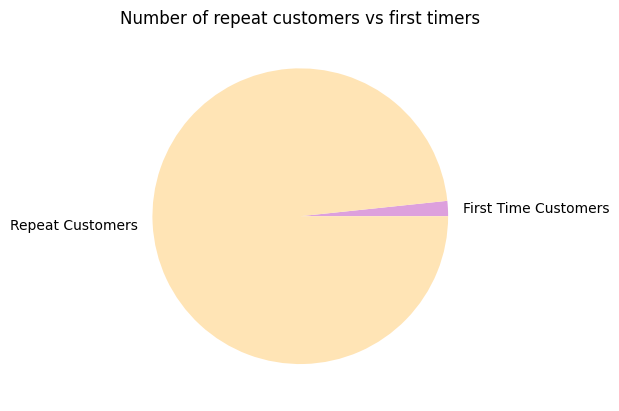

In [51]:
mylabels=["First Time Customers","Repeat Customers"]
plt.title("Number of repeat customers vs first timers")
plt.pie([len(first_time),len(repeat)],labels = mylabels,colors = ['plum', 'moccasin'])

From this plot we can see that > 95% of customers have made multiple purchases and hence the customer retention rate of the company is good.

## 2. Retention rate country wise : 

In [20]:
#Data engineeering : 
df_clean = df[df['Quantity'] >= 0]
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['Year'] = df_clean['InvoiceDate'].dt.year

df2010=df_clean[df_clean['Year'] == 2010]
final2010=[]
df2010group=df2010.groupby(['Country'])['CustomerID'].nunique()
list_2010 = df2010group.tolist() #List of values 

df2010list=df2010group.axes #List of countries

for i in range(len(list_2010)):
    final2010.append([df2010list[0][i],list_2010[i]])

df2010list=df2010list[0].tolist()
df2010group=df2010.groupby(['Country'])['CustomerID'].nunique()
df2010list=df2010group.axes
df2010list=df2010list[0].tolist()

df2011=df_clean[df_clean['Year'] == 2011]
final2011=[]
df2011group=df2011.groupby(['Country'])['CustomerID'].nunique()
list_2011 = df2011group.tolist()

df2011list=df2011group.axes

for i in range(len(list_2011)):
    final2011.append([df2011list[0][i],list_2011[i]])
df2011list=df2011list[0].tolist()

df2011list.append('Lithuania')
list_2011.append(0)

#Computing the growth : 

country_list=[]
change_list=[]
for i in range(0,len(df2010list)):
    temp=df2011list.index(df2010list[i])
    country = df2011list[temp]

    val2010 = list_2010[i]
    val2011 = list_2011[temp]
    
    if(val2010==0):
        country_list.append(df2010list[i])
        change_list.append(0)
    else:
        change = (val2011-val2010)/val2010
        country_list.append(df2010list[i])
        change_list.append(change)


/var/folders/mr/kssk23v57tb4236qqsb_hp1m0000gp/T/ipykernel_12083/3793910601.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
/var/folders/mr/kssk23v57tb4236qqsb_hp1m0000gp/T/ipykernel_12083/3793910601.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Year'] = df_clean['InvoiceDate'].dt.year


Text(0, 0.5, 'Retention %')

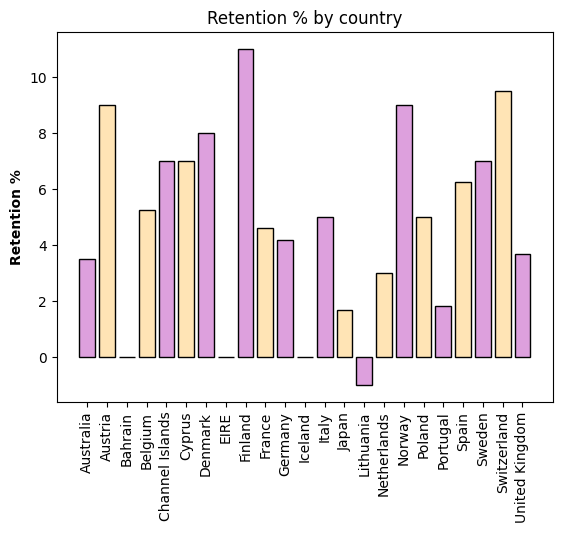

In [21]:
#Plotting the growth rate : 
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('white')

plt.xticks(ticks=range(len(country_list)), labels=country_list, rotation=90)
plt.bar(country_list,change_list, color=['plum', 'moccasin'],edgecolor = "black")
plt.title("Retention % by country")
plt.ylabel("Retention %", fontweight='bold')

## 3. Sales per country annualised

In [136]:
#Creating a subset having the reqiuered variables
df_topitems = df[df['Quantity'] >= 0]
df_topitems['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df_topitems['InvoiceDate'] = pd.to_datetime(df_topitems['InvoiceDate'])
df_topitems['Year'] = df_topitems['InvoiceDate'].dt.year

#Creating subsets for 2010 and 2011 and grouping them by country
df_sum_2010 = df_topitems[df_topitems['Year']==2010]
df_sum_2010 =df_sum_2010.groupby(['Country']).sum()

df_sum_2011 = df_topitems[df_topitems['Year']==2011]
df_sum_2011 =df_sum_2011.groupby(['Country']).sum()

#Extracting the list of countries in 2010 and 2011
bar_list2011=df_sum_2011.axes[0].tolist()
bar_list2010=df_sum_2010.axes[0].tolist()

#Extracting the total sales country wise in 2010 and 2011
bar_sales2011 = df_sum_2011['TotalPrice'].tolist()
bar_sales2010 = df_sum_2010['TotalPrice'].tolist()

#Dropping Lithuaina from the 2010 list as it doesnt exist in the 2011 list
bar_list2010.pop(14)
bar_sales2010.pop(14)

#Creating a list which has the sales data from 2010 and dimensions of 2011 lists. Whichever country wasnt recorded in 2010 is assigned 0
final_sales2010=[]
count=0
for i in range(len(bar_list2011)):
    country2011 = bar_list2011[i]
    if(country2011 in bar_list2010):
        final_sales2010.append(bar_sales2010[count])
        count=count+1
    else:
        final_sales2010.append(0)
        
#Dropping United Kingdom for scaling purposes

test2010=bar_list2010.copy()
test2010.pop()
test2010.pop()
val2010=final_sales2010.copy()
val2010.pop()
uk2010=val2010.pop()

test2011=bar_list2011.copy()
test2011.pop()
test2011.pop()
val2011=bar_sales2011.copy()
val2011.pop()
uk2011=val2011.pop()

/var/folders/mr/kssk23v57tb4236qqsb_hp1m0000gp/T/ipykernel_12083/3514464664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topitems['TotalPrice'] = df['Quantity'] * df['UnitPrice']


1032.85
277.2
205.74
1809.91
363.53
1590.82
1281.5
10033.26
892.8
9616.31
15241.14
711.79
811.5
7705.07
8784.48
3787.12
248.16
2439.9700000000003
1843.73
3834.2999999999997
1304.92
748268.98


/var/folders/mr/kssk23v57tb4236qqsb_hp1m0000gp/T/ipykernel_12083/3514464664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topitems['InvoiceDate'] = pd.to_datetime(df_topitems['InvoiceDate'])
/var/folders/mr/kssk23v57tb4236qqsb_hp1m0000gp/T/ipykernel_12083/3514464664.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topitems['Year'] = df_topitems['InvoiceDate'].dt.year
/var/folders/mr/kssk23v57tb4236qqsb_hp1m0000gp/T/ipykernel_12083/3514464664.py:8: FutureWarning: The default value of numeric_o

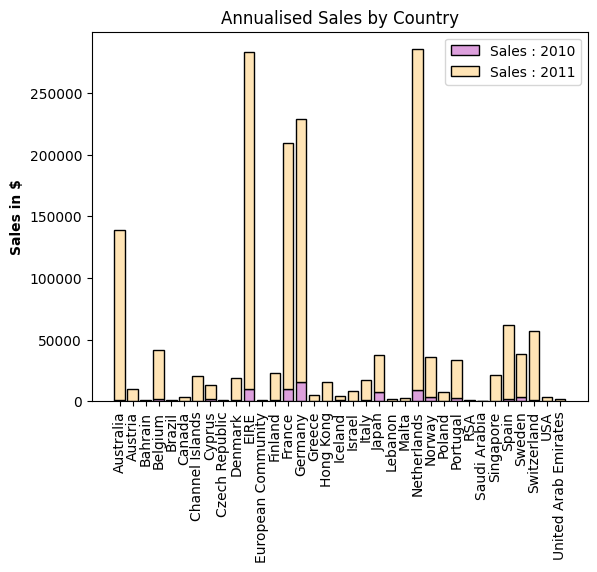

In [156]:
#Plotting the graphs 

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('white')

plt.title("Annualised Sales by Country")
plt.ylabel("Sales in $", fontweight='bold')

plt.xticks(ticks=range(len(test2011)), labels=test2011, rotation=90)
plt.bar(test2011,val2011)

x1=plt.bar(test2011, val2010, color='plum',edgecolor = "black")
x2=plt.bar(test2011, val2011, bottom=val2010, color='moccasin',edgecolor = "black")

plt.legend([x1, x2], ['Sales : 2010', 'Sales : 2011'])

In the above graph, we can see that the sales of most countries in 2010 was very poor and absolutelty insignificant. However, to view this on a better scale, we have also plotted the graphs seperately. 

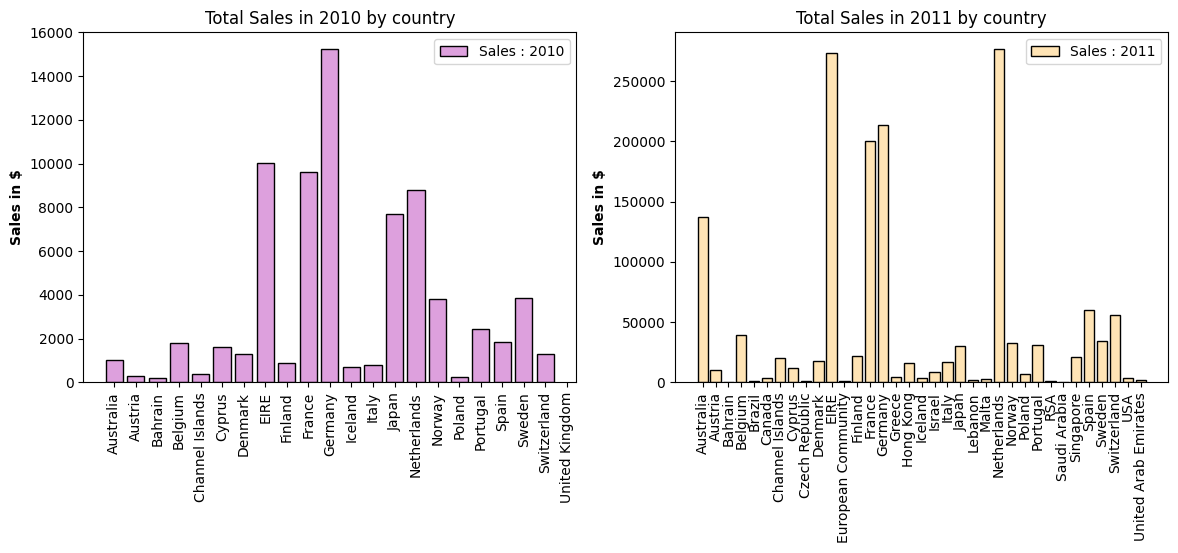

In [230]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.xticks(ticks=range(len(bar_list2010)), labels=bar_list2010, rotation=90)
x1=plt.bar(only2010_bar,only2010_sales,color=['plum'],edgecolor = "black")

plt.title("Total Sales in 2010 by country")
plt.ylabel("Sales in $", fontweight='bold')

plt.legend([x1], ['Sales : 2010'])

plt.subplot(2,2,2)
plt.xticks(ticks=range(len(test2011)), labels=test2011, rotation=90)
x1=plt.bar(test2011,val2011,color=['moccasin'],edgecolor = "black")

plt.title("Total Sales in 2011 by country")
plt.ylabel("Sales in $", fontweight='bold')

plt.legend([x1], ['Sales : 2011'])


In the above graphs, the value for United Kingdom has been left out due to scaling issues. Comparision of sales of United Kingdom are given below. 

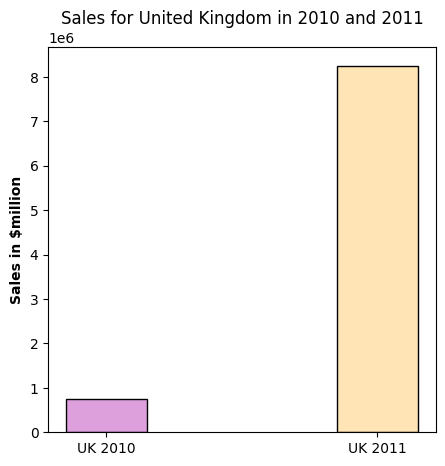

In [160]:
plt.figure(figsize=(5,5)) 
plt.title("Sales for United Kingdom in 2010 and 2011")
plt.ylabel("Sales in $million", fontweight='bold')
x1=plt.bar(["UK 2010","UK 2011"],[uk2010,uk2011],color=['plum', 'moccasin'],edgecolor = "black",width=0.3)

## 4. Customer Segmentation 

In [4]:
df['InvoiceDate'].max()
df['TotalPrice'] = df['Quantity']*df['UnitPrice']
today_date = dt.datetime(2011,12,11)

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (today_date - x.max()).days,
                                    'InvoiceNo': lambda x: x.nunique(),
                                    'TotalPrice': lambda x: x.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']
#rfm['monetary'] = rfm[rfm['monetary'] > 0]
rfm = rfm.reset_index()

rfm.head() 

#Here, we are assigning certain scores to the customers based on their purchase history.
#We count the recency based on the number of days passed since the last purchase
#We determine the frequency based on the number of unique invoice numbers of the user
#The monetary is the total sums of purchase made by each consumer 

,CustomerID,recency,frequency,monetary
0,12346.0,326,2,0.00
1,12347.0,3,7,4310.00
2,12348.0,76,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,311,1,334.40


In [53]:
rfm['Country']

1              Iceland
2              Finland
3                Italy
4               Norway
5               Norway
             ...      
4367    United Kingdom
4368    United Kingdom
4369    United Kingdom
4370    United Kingdom
4371    United Kingdom
Name: Country, Length: 4320, dtype: object

In [5]:
drop_values1=rfm[rfm['monetary']<=0].index

In [6]:
for i in drop_values1:
    
    rfm=rfm.drop(i) 
#We remove those values where total score is 0 since these customers havent really made any purchases

In [7]:
rfm_country=[]
for i in rfm['CustomerID']:
    cust_country=df['Country'][df['CustomerID']==i]
    rfm_country.append(cust_country.tolist()[0])
rfm['Country']=rfm_country

In [8]:
rfm_customers=rfm_stats['CustomerID'].tolist() 
#Put this as the top of the bar to indicate the max spender

NameError: name 'rfm_stats' is not defined

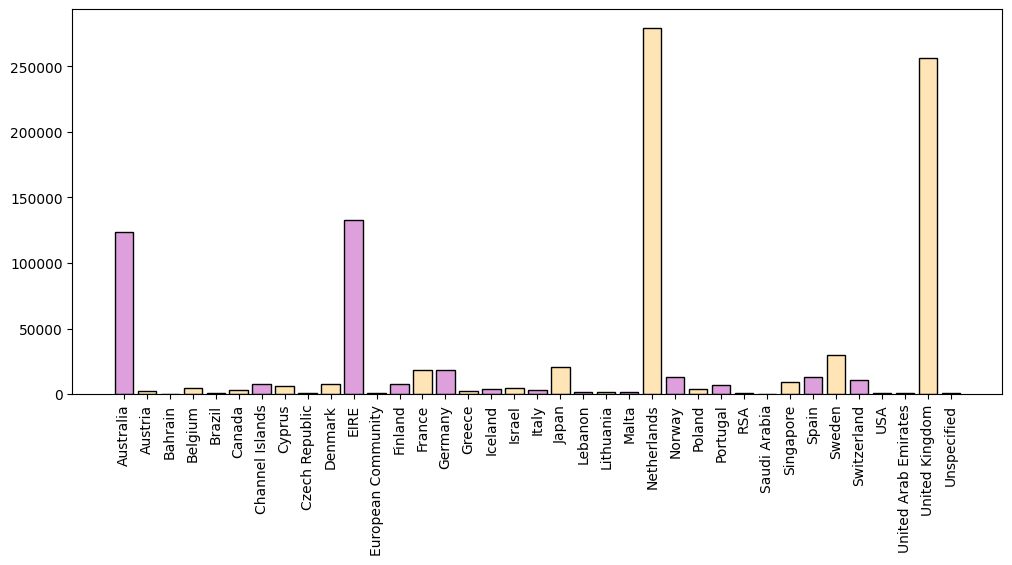

In [9]:
plt.figure(figsize=(12,5)) 
rfm_stats=rfm.groupby(['Country']).max()


plt.xticks(ticks=range(len(rfm_stats.axes[0].tolist())), labels=rfm_stats.axes[0].tolist(), rotation=90)

rfm_stats.sort_values(by='monetary', ascending=False)
x=plt.bar(rfm_stats.axes[0].tolist(),rfm_stats['monetary'],color=['plum', 'moccasin'],edgecolor = "black")


This graph shows us the biggest spenders per conutry.

In [10]:
def get_rfm_scores(dataframe) -> pd.core.frame.DataFrame:

    df_ = dataframe.copy()
    df_["recency_score"] = pd.qcut(df_["recency"], 5, labels=[5, 4, 3, 2, 1])
    df_["frequency_score"] = pd.qcut(
        df_["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]
    )
    df_["monetary_score"] = pd.qcut(df_["monetary"], 5, labels=[1, 2, 3, 4, 5])
    df_["RFM_SCORE"] = df_["recency_score"].astype(str) + df_["frequency_score"].astype(
        str
    )

    return df_


rfm = get_rfm_scores(rfm)
#This function creates a new dataframe after encoding the scores using Qcuts. Qcut distirbutes the values into x number of quartiles specified by the user

In [11]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)

#Here, we are assinging labels based on the 2 segment values. 

In [95]:
rfm

,CustomerID,recency,frequency,monetary,Country,recency_score,frequency_score,monetary_score,RFM_SCORE
1,12347.0,3,7,4310.00,Iceland,5,4,5,54
2,12348.0,76,4,1797.24,Finland,2,3,4,23
3,12349.0,19,1,1757.55,Italy,4,1,4,41
4,12350.0,311,1,334.40,Norway,1,1,2,11
5,12352.0,37,11,1545.41,Norway,3,5,4,35
...,...,...,...,...,...,...,...,...,...
4367,18280.0,278,1,180.60,United Kingdom,1,2,1,12
4368,18281.0,181,1,80.82,United Kingdom,1,2,1,12
4369,18282.0,8,3,176.60,United Kingdom,5,3,1,53
4370,18283.0,4,16,2094.88,United Kingdom,5,5,5,55


Text(0, 0.5, 'Recency')

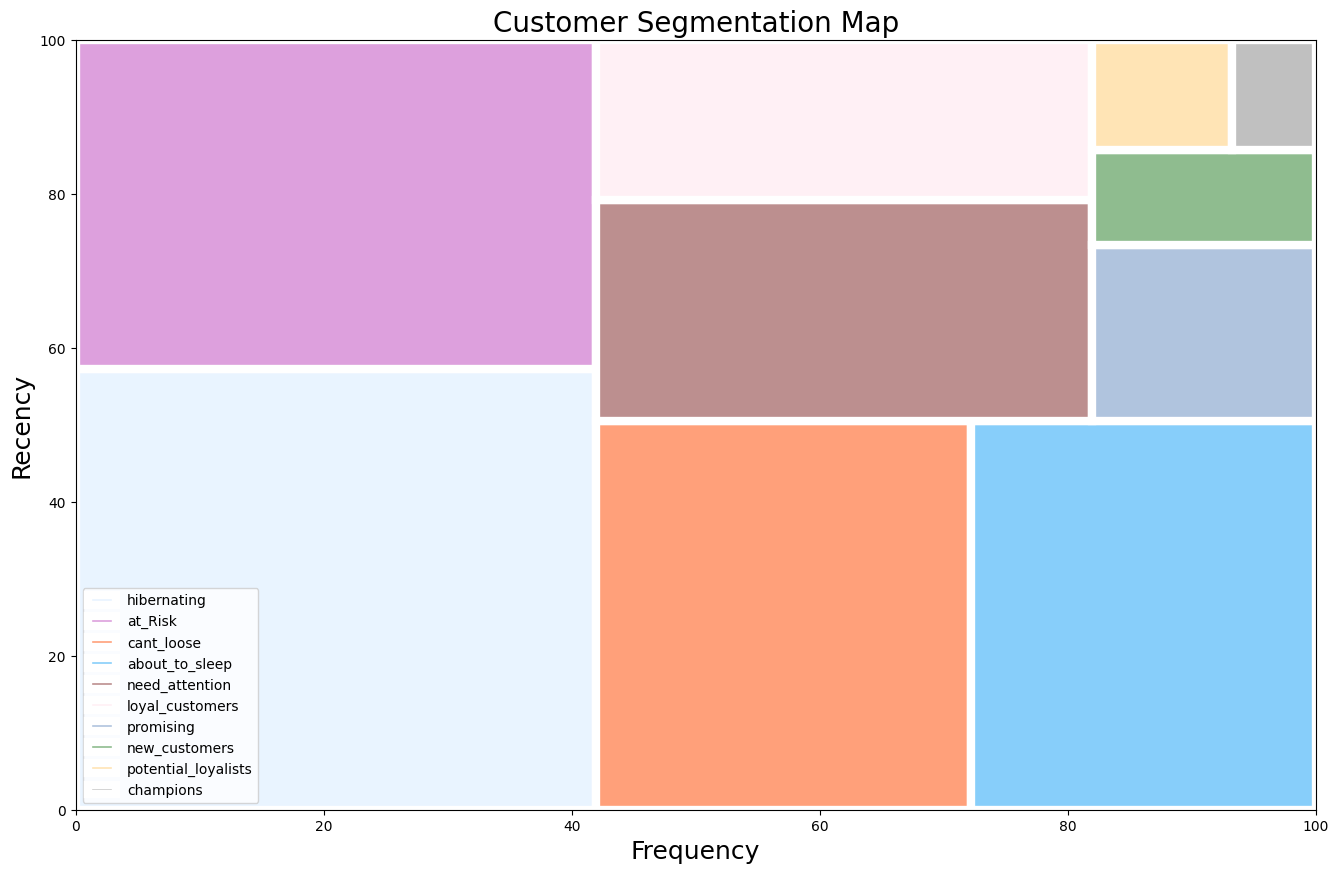

In [15]:
import squarify
segments = rfm["segment"].value_counts().sort_values(ascending=False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
labels=[label for label in seg_map.values()]
squarify.plot(
    sizes=segments,
    edgecolor="white", linewidth=6,
    color=[
        "#E9F4FF",
        "plum",
        "lightsalmon",
        "lightskyblue",
        "rosybrown",
        "lavenderblush",
        "lightsteelblue",
        "darkseagreen",
        "moccasin",
        "silver",
    ],
    pad=False,
    bar_kwargs={"alpha": 1},
    text_kwargs={"fontsize": 15},
)
plt.legend(handles=ax.containers[0], labels=labels,loc=3)
plt.title("Customer Segmentation Map", fontsize=20)
plt.xlabel("Frequency", fontsize=18)
plt.ylabel("Recency", fontsize=18)


This map gives us the number of customers under a given segment and shows us the Frequency and Recency values for that segment. Hence, The customers which lie to the top right are the ones which have made most purchases and most recently made those purchases, meanwhile the ones at the bottom have made the lowest number of purchases and they made it a while ago.

Higher the recency, the lesser number of days since the last purchase.
The higher the Frequency, the more number of total purchases(unique order id for a given customer id) 

## Task 3 : Machine Learning Model for Customer Recommender

In [29]:
data_main

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [31]:
data_main.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133626
Country             0
dtype: int64

Since the Customer ID is requiered for furthur processing , we need to drop all those which are null.

In [3]:
df_r = data_main.dropna()

In [4]:
df_r.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

We also know that some orderes were cancelled and we need to remove these too.

In [5]:
drop_values=df_r[df_r['StockCode'].str.endswith('C')].index

In [6]:
drop_values

Int64Index([    87,     91,    121,    154,    176,    200,    297,    373,
               396,    483,
            ...
            539902, 540095, 540119, 540150, 540152, 540161, 540375, 541649,
            541778, 541809],
           dtype='int64', length=4171)

In [7]:
for i in drop_values:
    df_r.drop(i)
    

In [44]:
df_r.shape

(406829, 8)

From the remainder of the dataset, we only need the UserId and StockCode. Also since the model we are applying is computationally intensive, we will have to cut the datatset and only provide a Proof of Concept, To do so , we will sort the data based on customers and pick the first 20,000 data points. 

In [8]:
df_r = df_r[['CustomerID','StockCode']]

In [9]:
df_r.sort_values(by=['CustomerID'])

,CustomerID,StockCode
61619,12346.0,23166
61624,12346.0,23166
286628,12347.0,21578
72263,12347.0,47559B
72264,12347.0,21154
...,...,...
392737,18287.0,23269
392736,18287.0,23223
392735,18287.0,23378
423939,18287.0,23264


In [10]:
df_work = df_r.head(20000)

In [79]:
len(df_work['CustomerID'].unique())

756

In [80]:
len(df_work['StockCode'].unique())

2226

We will now be working with data for 756 customers and 2226 products that they have purchased.

In [11]:
df2 = df_work.pivot_table(index = ['CustomerID', 'StockCode'], aggfunc ='size')

df2 has the Quantity of a Stock purchased by a customer. Now we need to transform this data to a dataframe. 

In [12]:
df2

CustomerID  StockCode
12347.0     20780        1
            20782        1
            21064        1
            21171        1
            21731        1
                        ..
18269.0     22449        1
            22450        1
            22451        1
            22617        1
            22837        1
Length: 17923, dtype: int64

In [13]:
df2=df2.to_frame()

In [14]:
df2

0
CustomerID StockCode   
12347.0    20780      1
           20782      1
           21064      1
           21171      1
           21731      1
...                  ..
18269.0    22449      1
           22450      1
           22451      1
           22617      1
           22837      1

[17923 rows x 1 columns]

In [16]:
final_dict = df2.to_dict()[0]

In [17]:
final_dict

{(12347.0, '20780'): 1,
 (12347.0, '20782'): 1,
 (12347.0, '21064'): 1,
 (12347.0, '21171'): 1,
 (12347.0, '21731'): 1,
 (12347.0, '22195'): 1,
 (12347.0, '22212'): 1,
 (12347.0, '22375'): 1,
 (12347.0, '22492'): 1,
 (12347.0, '22494'): 1,
 (12347.0, '22497'): 1,
 (12347.0, '22725'): 1,
 (12347.0, '22726'): 1,
 (12347.0, '22727'): 1,
 (12347.0, '22728'): 1,
 (12347.0, '22729'): 1,
 (12347.0, '22771'): 1,
 (12347.0, '22772'): 1,
 (12347.0, '22773'): 1,
 (12347.0, '22774'): 1,
 (12347.0, '22775'): 1,
 (12347.0, '22805'): 1,
 (12347.0, '71477'): 1,
 (12347.0, '84558A'): 1,
 (12347.0, '84969'): 1,
 (12347.0, '84997B'): 1,
 (12347.0, '84997C'): 1,
 (12347.0, '84997D'): 1,
 (12347.0, '85116'): 1,
 (12347.0, '85167B'): 1,
 (12347.0, '85232D'): 1,
 (12370.0, '18097C'): 1,
 (12370.0, '20707'): 1,
 (12370.0, '20846'): 1,
 (12370.0, '20961'): 1,
 (12370.0, '20963'): 1,
 (12370.0, '20966'): 1,
 (12370.0, '20967'): 1,
 (12370.0, '20969'): 1,
 (12370.0, '20970'): 1,
 (12370.0, '20972'): 1,
 (12370.0

In [18]:
cust = []
code = []
rating=[]

In [19]:
for i in list(final_dict.keys()):
    cust.append(i[0])
    code.append(i[1])
rating = list(final_dict.values())

In [20]:
df_recommend = pd.DataFrame(list(zip(cust, code,rating)),
               columns =['CustomerId', 'StockCode','Qty'])

In [21]:
df_recommend

,CustomerId,StockCode,Qty
0,12347.0,20780,1
1,12347.0,20782,1
2,12347.0,21064,1
3,12347.0,21171,1
4,12347.0,21731,1
...,...,...,...
17918,18269.0,22449,1
17919,18269.0,22450,1
17920,18269.0,22451,1
17921,18269.0,22617,1


This is the final Dataframe that we will be applying our support vector decomposition on. 

In [22]:
ratings_utility_matrix = df_recommend.pivot_table(values='Qty', index='CustomerId', columns='StockCode', fill_value=0)
ratings_utility_matrix.head()

StockCode,10002,10120,10123C,10124A,10124G,10125,10133,10135,11001,15034,...,90214J,90214K,90214M,90214S,90214V,BANK CHARGES,C2,D,M,POST
CustomerId,,,,,,,,,,,,,,,,,,,,,
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12370.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12386.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12395.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12427.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


This is our Matrix wherein the X axis has the Product Code and the Y Axis has the detail of the customer. 
The intersection has the Quantity said customer has purchsed of said product. 

In [23]:
X = ratings_utility_matrix.T
X.head()
X1 = X

In [24]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(2226, 10)

Here is where we reduce the above matrix into a matrix having only 10 columns without losing any data. 
Now, we will find the correlation of each product with every other product. 
For a given product P , the 10 most hihgly correlated products are the ones the customer is most likely to buy based on the Support Vector Decompositon.
We have shown an example of this in the code below.

In [25]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(2226, 2226)

In [43]:
testdata = X.index[322]

In [28]:
testdata2 = X.index[192]

In [44]:
testdata

'21205'

In [45]:
product_names = list(X.index)
product_ID = product_names.index(testdata)
product_ID

322

In [46]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(2226,)

In [47]:
recommended_products = list(X.index[correlation_product_ID > 0.90])
recommended_products.remove(testdata) 

recommended_products[0:9]

['16014',
 '16016',
 '20777',
 '21587',
 '21680',
 '22044',
 '22144',
 '22359',
 '22360']

In [48]:
for i in recommended_products[0:9]:
    print(data_main.loc[data_main['StockCode'] == i]['Description'].unique()[0])
  

SMALL CHINESE STYLE SCISSOR
LARGE CHINESE STYLE SCISSOR
CHRYSANTHEMUM NOTEBOOK
COSY HOUR GIANT TUBE MATCHES
WOODLAND  STICKERS
CHRISTMAS CARD STACK OF PRESENTS
CHRISTMAS CRAFT LITTLE FRIENDS
GLASS JAR KINGS CHOICE
GLASS JAR ENGLISH CONFECTIONERY


In [49]:
print(data_main.loc[data_main['StockCode'] == testdata]['Description'].unique()[0])

MULTICOLOUR 3D BALLS GARLAND


In [53]:
def findRecommend(testdata):
    product_names = list(X.index)
    product_ID = product_names.index(testdata)
    correlation_product_ID = correlation_matrix[product_ID]
    recommended_products = list(X.index[correlation_product_ID > 0.90])
    recommended_products.remove(testdata) 
    print("The product previously purchased is " + data_main.loc[data_main['StockCode'] == testdata]['Description'].unique()[0])
    print("")
    print("The user is most likely to purchase the following :-")
    print("")
    for i in recommended_products[0:9]:
        print(data_main.loc[data_main['StockCode'] == i]['Description'].unique()[0])


    

In [54]:
findRecommend(X.index[324])

The product previously purchased is SKULL AND CROSSBONES  GARLAND 

The user is most likely to purchase the following :-

ASS COL SMALL SAND GECKO P'WEIGHT
ASS COL LARGE SAND FROG P'WEIGHT
CRAZY DAISY HEART DECORATION
PARTY FOOD SHOPPER BAG
LARGE CAKE TOWEL, CHOCOLATE SPOTS
SET 6 FOOTBALL CELEBRATION CANDLES
RED SPOTTY BISCUIT TIN
RED RETROSPOT PLATE 
GREEN POLKADOT PLATE 
